In [1]:
import sys
!{sys.executable} -m pip install matplotlib pandas xlrd seaborn tqdm scikit-learn tensorflow keras protobuf

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tqdm
import numpy as np

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, BatchNormalization, LeakyReLU, Activation
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

Чтение данных из Excel

In [2]:
sales = pd.read_excel('ДанныеДекабря_2017.xlsx', 'Продажи')
sales = sales.set_index('Material')

ap = pd.read_excel('ДанныеДекабря_2017.xlsx', 'Магазины')
ap = ap.set_index('Material')

stock = pd.read_excel('ДанныеДекабря_2017.xlsx', 'Остатки')
stock = stock.set_index('Material')

price = pd.read_excel('ДанныеДекабря_2017.xlsx', 'Цены')
price = price.set_index('Material')

hierarchy = pd.read_excel('hierarchy.xlsx')

sell = pd.read_excel('Акции.xlsx')

Создание DataFrame для анализа зависимостей между переменными по артикулам

In [3]:
full_train_data = pd.DataFrame()

for x in tqdm.tqdm(sales.index[:]):
    material = x

    df = pd.concat([sales.loc[material].rename('sales'),\
               sales.loc[material].shift(-1).rename('sales_1'),\
               sales.loc[material].shift(-2).rename('sales_2'),\
               sales.loc[material].shift(-12).rename('sales_12'),\
               sales.loc[material].subtract(sales.loc[material].shift(-1)).rename('sales_diff_1'),\
               sales.loc[material].subtract(sales.loc[material].shift(-2)).rename('sales_diff_2'),\
               sales.loc[material].subtract(sales.loc[material].shift(-12)).rename('sales_diff_12'),\
               stock.loc[material].shift(-1).rename('stock_1'),\
               stock.loc[material].shift(-2).rename('stock_2'),\
               stock.loc[material].subtract(stock.loc[material].shift(-1)).rename('stock_diff_1'),\
               stock.loc[material].subtract(stock.loc[material].shift(-2)).rename('stock_diff_2'),\
               price.loc[material].shift(-1).rename('price_1'),\
               price.loc[material].shift(-1).rename('price_2'),\
               price.loc[material].subtract(price.loc[material].shift(-1)).rename('price_diff_1'),\
               price.loc[material].subtract(price.loc[material].shift(-1)).rename('price_diff_2'),\
               ap.loc[material].shift(-1).rename('ap_1'),\
               ap.loc[material].shift(-1).rename('ap_2'),\
               ap.loc[material].subtract(ap.loc[material].shift(-1)).rename('ap_diff_1'),\
               ap.loc[material].subtract(ap.loc[material].shift(-1)).rename('ap_diff_2')],\
              axis=1)

    df = df.dropna()

    df.loc[:,'material'] = material
    
    full_train_data = full_train_data.append(df)
    
full_train_data.loc[:,'month'] = full_train_data.index.month

In [5]:
del sales
del ap
del stock
del price
del hierarchy
del sell

Сохраняем собранные данные в файл для ускорения в будущем

In [4]:
full_train_data.to_excel('full_train_data.xlsx')

Выгружаем данные для обучения из файла

In [3]:
full_train_data = pd.read_excel('full_train_data.xlsx')

Создаем DF корелляции

In [5]:
df_columns_filter = ['sales','sales_1','sales_2','sales_12',
                     'sales_diff_1','sales_diff_2','sales_diff_12',
                     'stock_1','stock_2',
                     'stock_diff_1','stock_diff_2',
                     'price_1','price_2',
                     'ap_1','ap_2',
                     'month','material']

In [6]:
corr_df = full_train_data[df_columns_filter].groupby('material').corr().abs().sales.fillna(0).unstack(level=0).T

Выделение групп артикулов для ращного прогнозирования на основе коррелляции

In [7]:
#Cluster the data
kmeans = KMeans(n_clusters=5, random_state=0).fit(corr_df)
labels = kmeans.labels_

#Glue back to originaal data
corr_df['clusters'] = labels

# Создание нормализованной DF
corr_overal_df = corr_df.groupby('clusters').mean()

corr_overal_norm_df = (corr_overal_df-corr_overal_df.min())/(corr_overal_df.max()-corr_overal_df.min())

Вычисление колонок у кластера для использования для прогнозирования

In [10]:
# Будем отсекать по средней корелляции, за исключением артикулов, у которых нет данных
threshold = corr_overal_df[corr_overal_df.sales > 0.1].mean()
# Инициализация копии DF
corr_thresh_df = corr_overal_df.copy()
# Прогон сравнения по всем колонкам
for col in corr_overal_df.columns:
    corr_thresh_df[col] = (corr_overal_df[col] >= threshold[col]).astype(int)
    
corr_thresh_df.style.background_gradient(cmap='viridis')

,ap_1,ap_2,month,price_1,price_2,sales,sales_1,sales_12,sales_2,sales_diff_1,sales_diff_12,sales_diff_2,stock_1,stock_2,stock_diff_1,stock_diff_2
clusters,,,,,,,,,,,,,,,,
0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,1
1,1,1,0,1,1,1,1,1,1,0,0,0,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1


In [11]:
def get_cluster_id(material_id):
    return corr_df.loc[material_id, 'clusters']

Создаем DF для всех материалов для обучения нейронки

In [12]:
train_data = full_train_data[df_columns_filter].merge(corr_df.clusters.to_frame(), how='left', left_on='material', right_index=True)

Создаем тренировочные данные

In [13]:
X = train_data[[col for col in train_data.columns if col not in ['sales', 'material']]]

Y = train_data.sales.to_frame()

scaler = MinMaxScaler()

print(scaler.fit(X))
print(scaler.fit(Y))

xscale=scaler.transform(X)
yscale=scaler.transform(Y)

X_train, X_test, y_train, y_test = train_test_split(xscale, yscale)

c:\python36\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))


c:\python36\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))


In [82]:
# 82.6%
model = Sequential()
model.add(Dense(32, input_dim=16, kernel_initializer='normal'))
model.add(Dense(16))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_38 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 17        
Total params: 1,089
Trainable params: 1,089
Non-trainable params: 0
_________________________________________________________________


In [83]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [ ]:
history = model.fit(X_train, y_train, epochs=200, batch_size=50, validation_data=(X_test, y_test), shuffle=True, verbose=1)

Train on 184590 samples, validate on 61530 samples
Epoch 1/200
184590/184590 [==============================] - 8s 42us/sample - loss: 6.2825 - mean_squared_error: 6.2824 - mean_absolute_error: 0.1467 - val_loss: 2.2323e-04 - val_mean_squared_error: 2.2324e-04 - val_mean_absolute_error: 0.0062
Epoch 2/200
184590/184590 [==============================] - 7s 39us/sample - loss: 1.3004 - mean_squared_error: 1.3003 - mean_absolute_error: 0.1227 - val_loss: 2.4416e-05 - val_mean_squared_error: 2.4416e-05 - val_mean_absolute_error: 0.0021
Epoch 3/200
184590/184590 [==============================] - 7s 40us/sample - loss: 0.3388 - mean_squared_error: 0.3388 - mean_absolute_error: 0.0773 - val_loss: 2.4429e-05 - val_mean_squared_error: 2.4429e-05 - val_mean_absolute_error: 0.0018
Epoch 4/200
184590/184590 [==============================] - 7s 40us/sample - loss: 0.3428 - mean_squared_error: 0.3428 - mean_absolute_error: 0.0317 - val_loss: 2.3696e-05 - val_mean_squared_error: 2.3696e-05 - val_m

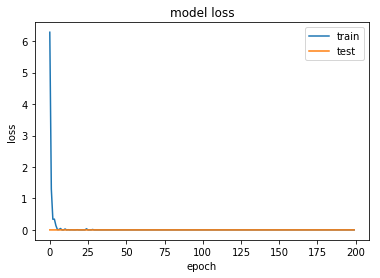

In [85]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [86]:
model.evaluate(X_test, y_test)

61530/61530 [==============================] - 3s 52us/sample - loss: 3.9425e-06 - mean_squared_error: 3.9425e-06 - mean_absolute_error: 8.0855e-04


[3.942458550267514e-06, 3.9424594e-06, 0.00080855197]

In [87]:
prediction = model.predict(X_test)

accuracy = 1 - sum(abs(scaler.inverse_transform(prediction) - scaler.inverse_transform(y_test))) / sum(scaler.inverse_transform(y_test))

print('Total accuracy = %.2f%%' % (accuracy * 100))

Total accuracy = 79.41%
